In [1]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import time

In [2]:
df = pd.read_csv("df_working.csv")
#df = df.sample(n=500000, random_state=42)

/var/folders/bp/8lh9bw_x6jb7fbg300yhf61h0000gn/T/ipykernel_87663/184150324.py:1: DtypeWarning: Columns (5,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_working.csv")


In [4]:
# Models to try
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    #'Random Forest': RandomForestRegressor(),
    # 'Decision Tree': DecisionTreeRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'XGBoost': XGBRegressor(verbosity=0), 
    #'Support Vector': SVR()
}

print(df['TELEHEALTHFLAG'])

0          2.0
1          2.0
2          2.0
3          2.0
4          2.0
          ... 
1007501    NaN
1007502    NaN
1007503    NaN
1007504    NaN
1007505    NaN
Name: TELEHEALTHFLAG, Length: 1007506, dtype: float64


In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Define columns
feature_cols = [
    'VISITTYPE', 'VSTCTGRY', 'DOCATLOC', 'DRSPLTY_M18',
    'MEDPTYPE_M18', 'SEEDOC_M18', 'SURGPROC', 'MEDPRESC', 'TELEHEALTHFLAG',
    'LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18',
    'OBDATEYR', 'OBDATEMM', 'insurance'
]

binary_cols = [
    'DOCATLOC', 'SEEDOC_M18', 'SURGPROC', 'MEDPRESC', 'TELEHEALTHFLAG', 
    'LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18'
]

# Fill NA and convert to string initially
df[feature_cols] = df[feature_cols].fillna('Missing')
df[feature_cols] = df[feature_cols].astype(str)


# Map binary features to numeric
for col in binary_cols:
    df[col] = df[col].map({'1.0': 1, '2.0': 0, 'Missing': np.nan})

# Build model dataframe
df_model = df[feature_cols + ['total_charge', 'out_of_pocket', 'COST_COVERED']]
df_model['log_total_charge'] = np.log1p(df_model['total_charge'])

# Define inputs and targets
X = df_model[feature_cols]

targets = {
    'Total Cost': df_model['total_charge'],
    'Out-of-Pocket': df_model['out_of_pocket'],
    'Cost Covered': df_model['COST_COVERED']
}

# Identify categorical columns = object types EXCLUDING binary numeric cols
categorical_cols = list(set(X.select_dtypes(include='object').columns) - set(binary_cols))

# Preprocessor: Categorical = impute + encode, pass binary and other numerics through
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pipeline, categorical_cols)
    ],
    remainder='passthrough'  # Binary and numeric features stay as-is
)


/var/folders/bp/8lh9bw_x6jb7fbg300yhf61h0000gn/T/ipykernel_87663/2195123835.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['log_total_charge'] = np.log1p(df_model['total_charge'])


In [6]:
# Check missing values in target variables
print("Missing values in targets:")
print(f"total_charge: {df_model['total_charge'].isna().sum()} missing")
print(f"out_of_pocket: {df_model['out_of_pocket'].isna().sum()} missing")
print(f"COST_COVERED: {df_model['COST_COVERED'].isna().sum()} missing")

Missing values in targets:
total_charge: 0 missing
out_of_pocket: 0 missing
COST_COVERED: 0 missing


In [10]:
# Fix the calendar feature conversion error
# Replace 'Missing' with np.nan first, then convert to numeric
df_model['visit_month'] = pd.to_numeric(df_model['OBDATEMM'].replace('Missing', np.nan), errors='coerce')
df_model['visit_year'] = pd.to_numeric(df_model['OBDATEYR'].replace('Missing', np.nan), errors='coerce')
df_model['visit_quarter'] = df_model['visit_month'].apply(lambda x: (x-1)//3 + 1 if not pd.isna(x) else np.nan)

# For categorical interaction features, keep them as strings
df_model['speciality_insurance'] = df_model['DRSPLTY_M18'].astype(str) + '_' + df_model['insurance'].astype(str)
df_model['visit_type_category'] = df_model['VISITTYPE'].astype(str) + '_' + df_model['VSTCTGRY'].astype(str)

# Test complexity - convert to numeric first
for test_col in ['LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18']:
    # These should already be converted to 0/1 with np.nan from your binary processing
    # But let's make sure
    if df_model[test_col].dtype == 'object':
        df_model[test_col] = pd.to_numeric(df_model[test_col].replace('Missing', np.nan), errors='coerce')

# Now create test complexity score
df_model['test_complexity'] = (df_model['LABTEST_M18'].fillna(0) + 
                         df_model['XRAYS_M18'].fillna(0) + 
                         (df_model['MRI_M18'].fillna(0) * 3) +  # MRIs are more expensive
                         df_model['EKG_M18'].fillna(0))

# Provider/facility type indicators
df_model['is_hospital'] = df_model['VSTCTGRY'].isin(['1.0']).astype(int)
df_model['is_outpatient'] = df_model['VSTCTGRY'].isin(['2.0']).astype(int) 
df_model['is_office'] = df_model['VSTCTGRY'].isin(['3.0']).astype(int)
df_model['is_emergency'] = df_model['VSTCTGRY'].isin(['4.0']).astype(int)

# Primary care vs. specialist
df_model['is_primary_care'] = df_model['DRSPLTY_M18'].isin(['1.0', '3.0']).astype(int)
df_model['is_specialist'] = (~df_model['DRSPLTY_M18'].isin(['1.0', '3.0', 'Missing'])).astype(int)

# Service combinations
df_model['surgical_with_imaging'] = ((df_model['SURGPROC'] == 1) & 
                                   ((df_model['XRAYS_M18'] == 1) | 
                                    (df_model['MRI_M18'] == 1))).astype(int)

# Visit complexity 
df_model['high_complexity'] = ((df_model['test_complexity'] > 1) | 
                             (df_model['SURGPROC'] == 1)).astype(int)

# Insurance-based features
df_model['has_insurance'] = (df_model['insurance'] != 'Uninsured').astype(int)

df_model['procedure_count'] = (df_model['LABTEST_M18'].fillna(0).astype(bool).astype(int) + 
                         df_model['XRAYS_M18'].fillna(0).astype(bool).astype(int) + 
                         df_model['MRI_M18'].fillna(0).astype(bool).astype(int) + 
                         df_model['EKG_M18'].fillna(0).astype(bool).astype(int) +
                         df_model['SURGPROC'].fillna(0).astype(bool).astype(int))

# Special visits are often more expensive
df_model['is_specialist'] = (~df_model['DRSPLTY_M18'].isin(['Missing', '1.0', '3.0'])).astype(int)
 
# Prescription indicator
df_model['has_prescription'] = (df_model['MEDPRESC'] == 1).astype(int)

# Define new feature columns list
feature_cols_enhanced = feature_cols + [
    'visit_month', 'visit_year', 'visit_quarter', 
    'test_complexity', 'procedure_count', 'is_specialist',
    'has_prescription', 'is_hospital', 'is_outpatient', 'is_office', 'is_emergency', 
    'is_primary_care', 'surgical_with_imaging', 'high_complexity', 'has_insurance'
]

/var/folders/bp/8lh9bw_x6jb7fbg300yhf61h0000gn/T/ipykernel_87663/4200489445.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['visit_month'] = pd.to_numeric(df_model['OBDATEMM'].replace('Missing', np.nan), errors='coerce')
/var/folders/bp/8lh9bw_x6jb7fbg300yhf61h0000gn/T/ipykernel_87663/4200489445.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['visit_year'] = pd.to_numeric(df_model['OBDATEYR'].replace('Missing', np.nan), errors='coerce')
/var/folders/bp/8lh9bw_x6jb7fbg300yhf61h0000g

In [11]:
print(df_model)

        VISITTYPE VSTCTGRY  DOCATLOC DRSPLTY_M18 MEDPTYPE_M18  SEEDOC_M18  \
0         Missing      1.0       NaN         8.0      Missing         1.0   
1         Missing      2.0       0.0     Missing          8.0         0.0   
2         Missing      1.0       NaN        14.0      Missing         1.0   
3         Missing      2.0       NaN        14.0      Missing         1.0   
4         Missing      2.0       NaN        14.0      Missing         1.0   
...           ...      ...       ...         ...          ...         ...   
1007501   Missing      1.0       NaN         6.0      Missing         1.0   
1007502   Missing      1.0       0.0     Missing         11.0         0.0   
1007503   Missing      1.0       NaN         8.0      Missing         1.0   
1007504   Missing      1.0       NaN         8.0      Missing         1.0   
1007505   Missing      5.0       NaN         8.0      Missing         1.0   

         SURGPROC  MEDPRESC  TELEHEALTHFLAG  LABTEST_M18  ...  is_outpatien

In [12]:
def remove_target_outliers(X, y, std_dev=3):
    """Remove extreme values from target variable"""
    mean = y.mean()
    std = y.std()
    mask = (y > mean - std_dev * std) & (y < mean + std_dev * std)
    
    print(f"Removing {(~mask).sum()} outliers from {len(y)} samples ({(~mask).sum()/len(y)*100:.2f}%)")
    
    return X[mask], y[mask]

In [ ]:
for target_name, y in targets.items():
    print(f"\n Prediction: {target_name}")
    start_target = time.time()

    # Combine features and actual target column (y is a Series with the correct column)
    df_model = pd.concat([X, y], axis=1)
    #df_with_na = df_model[df_model.isna().any(axis=1)]
    #print(df_with_na)
    #num_na_rows = df_model.isna().any(axis=1).sum()
    #print(f"{num_na_rows} rows contain at least one NA value.")
    df_model = df_model.dropna()



    X_clean = df_model[feature_cols]
    y_clean = df_model[y.name]  # Get actual column name from Series

    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42
    )

    for model_name, model in models.items():
    #for model_name, model in tqdm(models.items(), desc=f"Models for {target_name}", leave=False):
        start_model = time.time()
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        #print(f"{model_name:20} | RMSE: {rmse:8.2f} | R²: {r2:.4f}")
        duration = time.time() - start_model
        print(f"{model_name} done in {duration:.2f}s | RMSE: {rmse:.2f}, R²: {r2:.4f}")

    print(f"✅ Finished {target_name} in {time.time() - start_target:.2f}s")



 Prediction: Total Cost
XGBoost done in 3.54s | RMSE: 3954.36, R²: -2.0847
✅ Finished Total Cost in 6.21s

 Prediction: Out-of-Pocket
XGBoost done in 1.89s | RMSE: 186.04, R²: 0.2293
✅ Finished Out-of-Pocket in 5.09s

 Prediction: Cost Covered
XGBoost done in 1.96s | RMSE: 4537.81, R²: -3.1221
✅ Finished Cost Covered in 4.44s


In [14]:
targets['Cost Covered'] = targets['Cost Covered'].clip(lower=0)

log_targets = {
    'Log Total Cost': np.log1p(targets['Total Cost']),
    'Log Out-of-Pocket': np.log1p(targets['Out-of-Pocket']),
    'Log Cost Covered': np.log1p(targets['Cost Covered'])
}

cost_types = ['Total Cost', 'Out-of-Pocket', 'Cost Covered']
importance_by_cost = {}

# Check for NaN or infinite values after log transformation
for target_name, y in log_targets.items():
    nan_count = y.isna().sum()
    inf_count = np.isinf(y).sum()
    print(f"{target_name}: {nan_count} NaNs, {inf_count} infinities")
    
    # Replace infinities with NaNs, then drop rows with NaNs
    log_targets[target_name] = y.replace([np.inf, -np.inf], np.nan)

# Modified training code with better error handling
for target_name, y in log_targets.items():
    print(f"\nPrediction: {target_name}")
    start_target = time.time()

    # Combine features and actual target column
    df_model = pd.concat([X, y], axis=1)
    df_model = df_model.dropna()  # Drop any rows with NaN values
    
    # Safety check - are there enough rows?
    if len(df_model) < 100:  # arbitrary threshold
        print(f"Warning: Only {len(df_model)} valid rows for {target_name}")
        continue

    # Check if any zeros in original data created -inf in log data
    if (y == -np.inf).any():
        print(f"Warning: {target_name} contains -inf values from log(0)")

    X_clean = df_model[feature_cols]
    y_clean = df_model[y.name]  # Get actual column name from Series
    X_clean, y_clean = remove_target_outliers(X_clean, y_clean, std_dev=3)
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42
    )

    try:
        for model_name, model in models.items():
            start_model = time.time()
            pipe = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('model', model)
            ])

            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)

            # Calculate metrics on transformed scale
            rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
            r2_log = r2_score(y_test, y_pred)
            
            # Try to calculate original scale metrics, but handle errors
            try:
                y_test_original = np.expm1(y_test)
                y_pred_original = np.expm1(y_pred)
                rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
                r2_original = r2_score(y_test_original, y_pred_original)
                duration = time.time() - start_model
                print(f"{model_name} done in {duration:.2f}s")
                print(f"  Log scale - RMSE: {rmse_log:.4f}, R²: {r2_log:.4f}")
                print(f"  Original scale - RMSE: {rmse_original:.2f}, R²: {r2_original:.4f}")
            except:
                print(f"{model_name} done in {duration:.2f}s")
                print(f"  Log scale - RMSE: {rmse_log:.4f}, R²: {r2_log:.4f}")
                print(f"  Original scale metrics calculation failed")
    
    except Exception as e:
        print(f"Error training model for {target_name}: {str(e)}")

    print(f"✅ Finished {target_name} in {time.time() - start_target:.2f}s")

baseline = y_test.mean()
print(f"Baseline RMSE: {np.sqrt(mean_squared_error(y_test, [baseline] * len(y_test))):.2f}")


Log Total Cost: 0 NaNs, 0 infinities
Log Out-of-Pocket: 0 NaNs, 0 infinities
Log Cost Covered: 0 NaNs, 0 infinities

Prediction: Log Total Cost
Removing 3705 outliers from 301310 samples (1.23%)
Linear Regression done in 3.03s
  Log scale - RMSE: 0.9109, R²: 0.1956
  Original scale - RMSE: 666.45, R²: -0.0003
Ridge Regression done in 1.44s
  Log scale - RMSE: 0.9109, R²: 0.1957
  Original scale - RMSE: 666.43, R²: -0.0003
Lasso Regression done in 1.12s
  Log scale - RMSE: 1.0157, R²: -0.0000
  Original scale - RMSE: 691.38, R²: -0.0766
AdaBoost done in 6.61s
  Log scale - RMSE: 0.9890, R²: 0.0518
  Original scale - RMSE: 662.88, R²: 0.0103
XGBoost done in 1.70s
  Log scale - RMSE: 0.8563, R²: 0.2891
  Original scale - RMSE: 650.00, R²: 0.0484
✅ Finished Log Total Cost in 14.93s

Prediction: Log Out-of-Pocket
Removing 483 outliers from 301310 samples (0.16%)
Linear Regression done in 1.40s
  Log scale - RMSE: 1.7128, R²: 0.2716
  Original scale - RMSE: 141.00, R²: -0.0346
Ridge Regressi

In [15]:
#FEATURE IMPORTANCE


def get_feature_names_from_preprocessor(preprocessor):
    """Extract feature names from the preprocessor pipeline"""
    feature_names = []
    
    # Handle different types of preprocessors
    if hasattr(preprocessor, 'get_feature_names_out'):
        # For newer scikit-learn versions
        feature_names = preprocessor.get_feature_names_out()
    elif hasattr(preprocessor, 'get_feature_names'):
        # For older scikit-learn versions
        feature_names = preprocessor.get_feature_names()
    else:
        # For custom preprocessors, try to extract from transformers
        try:
            for name, transformer, columns in preprocessor.transformers_:
                if hasattr(transformer, 'get_feature_names_out'):
                    trans_features = transformer.get_feature_names_out()
                elif hasattr(transformer, 'get_feature_names'):
                    trans_features = transformer.get_feature_names()
                else:
                    trans_features = columns
                feature_names.extend(trans_features)
        except:
            # Fallback to numbered features
            feature_names = [f'feature_{i}' for i in range(preprocessor.transform(X_train.iloc[:1]).shape[1])]
    
    return feature_names


# Add feature importance analysis after model fitting
for target_name, y in log_targets.items():
    print(f"\nPrediction: {target_name}")
    start_target = time.time()

    # Combine features and actual target column
    df_model = pd.concat([X, y], axis=1)
    df_model = df_model.dropna()  # Drop any rows with NaN values
    
    # Safety check - are there enough rows?
    if len(df_model) < 100:  # arbitrary threshold
        print(f"Warning: Only {len(df_model)} valid rows for {target_name}")
        continue

    # Check if any zeros in original data created -inf in log data
    if (y == -np.inf).any():
        print(f"Warning: {target_name} contains -inf values from log(0)")

    X_clean = df_model[feature_cols]
    y_clean = df_model[y.name]  # Get actual column name from Series
    X_clean, y_clean = remove_target_outliers(X_clean, y_clean, std_dev=3)
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42
    )

    # Store feature importances for this cost type
    cost_type = target_name.replace('Log ', '')
    importance_by_cost[cost_type] = {}

    try:
        for model_name, model in models.items():
            start_model = time.time()
            pipe = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('model', model)
            ])

            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)

            # Calculate metrics on transformed scale
            rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
            r2_log = r2_score(y_test, y_pred)
            
            # Try to calculate original scale metrics, but handle errors
            try:
                y_test_original = np.expm1(y_test)
                y_pred_original = np.expm1(y_pred)
                rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
                r2_original = r2_score(y_test_original, y_pred_original)
                
                duration = time.time() - start_model  # Fix: Added this line to calculate duration
                
                print(f"{model_name} done in {duration:.2f}s")
                print(f"  Log scale - RMSE: {rmse_log:.4f}, R²: {r2_log:.4f}")
                print(f"  Original scale - RMSE: {rmse_original:.2f}, R²: {r2_original:.4f}")
            except Exception as e:
                duration = time.time() - start_model  # Fix: Added this line to calculate duration
                print(f"{model_name} done in {duration:.2f}s")
                print(f"  Log scale - RMSE: {rmse_log:.4f}, R²: {r2_log:.4f}")
                print(f"  Original scale metrics calculation failed: {str(e)}")
            
            # Extract feature importances if model supports it
            if hasattr(model, 'feature_importances_') or (hasattr(model, 'coef_')):
                feature_names = get_feature_names_from_preprocessor(preprocessor)
                
                # Get feature importances based on model type
                if model_name in ['RandomForest', 'GradientBoosting', 'XGBoost']:
                    # For tree-based models
                    feature_importances = pipe.named_steps['model'].feature_importances_
                elif model_name in ['Linear', 'Ridge', 'Lasso']:
                    # For linear models
                    feature_importances = np.abs(pipe.named_steps['model'].coef_)
                else:
                    print(f"Feature importance not implemented for {model_name}")
                    continue
                
                # Create a DataFrame with feature names and importances
                if len(feature_names) == len(feature_importances):
                    importance_df = pd.DataFrame({
                        'Feature': feature_names,
                        'Importance': feature_importances
                    }).sort_values('Importance', ascending=False)
                    
                    # Store top features for this model and cost type
                    importance_by_cost[cost_type][model_name] = importance_df.head(10)
                    
                    # Print top 5 features
                    print(f"  Top 5 important features for {model_name}:")
                    for i, (feature, importance) in enumerate(zip(importance_df['Feature'].head(5), 
                                                                 importance_df['Importance'].head(5))):
                        print(f"    {i+1}. {feature}: {importance:.4f}")
                else:
                    print(f"  Feature names and importances length mismatch: {len(feature_names)} vs {len(feature_importances)}")
    
    except Exception as e:
        print(f"Error training model for {target_name}: {str(e)}")

    print(f"✅ Finished {target_name} in {time.time() - start_target:.2f}s")

# Now visualize feature importances across models and cost types
for cost_type, model_importances in importance_by_cost.items():
    print(f"\n=== Feature Importance for {cost_type} ===")
    
    # Combine importances from different models
    if len(model_importances) > 0:
        # Aggregate feature importances across models
        all_features = set()
        for model_name, importance_df in model_importances.items():
            all_features.update(importance_df['Feature'].tolist())
        
        # Create a summary DataFrame showing top features across multiple models
        summary_df = pd.DataFrame(index=list(all_features), columns=model_importances.keys())
        
        for model_name, importance_df in model_importances.items():
            for _, row in importance_df.iterrows():
                summary_df.loc[row['Feature'], model_name] = row['Importance']
        
        # Fill NaN values with 0
        summary_df = summary_df.fillna(0)
        
        # Add average importance across models
        summary_df['Average'] = summary_df.mean(axis=1)
        
        # Sort by average importance
        summary_df = summary_df.sort_values('Average', ascending=False)
        
        # Print top 10 features by average importance
        print("Top 10 features by average importance:")
        print(summary_df.head(10))
    else:
        print("No feature importances available for this cost type")


Prediction: Log Total Cost
Removing 3705 outliers from 301310 samples (1.23%)
Linear Regression done in 1.37s
  Log scale - RMSE: 0.9109, R²: 0.1956
  Original scale - RMSE: 666.45, R²: -0.0003
Feature importance not implemented for Linear Regression
Ridge Regression done in 1.11s
  Log scale - RMSE: 0.9109, R²: 0.1957
  Original scale - RMSE: 666.43, R²: -0.0003
Feature importance not implemented for Ridge Regression
Lasso Regression done in 0.91s
  Log scale - RMSE: 1.0157, R²: -0.0000
  Original scale - RMSE: 691.38, R²: -0.0766
Feature importance not implemented for Lasso Regression
AdaBoost done in 7.47s
  Log scale - RMSE: 0.9781, R²: 0.0726
  Original scale - RMSE: 662.73, R²: 0.0108
Feature importance not implemented for AdaBoost
XGBoost done in 1.45s
  Log scale - RMSE: 0.8563, R²: 0.2891
  Original scale - RMSE: 650.00, R²: 0.0484
  Top 5 important features for XGBoost:
    1. cat__VSTCTGRY_6.0: 0.1375
    2. cat__MEDPTYPE_M18_10.0: 0.1069
    3. remainder__DOCATLOC: 0.1011


/var/folders/bp/8lh9bw_x6jb7fbg300yhf61h0000gn/T/ipykernel_87663/3595836426.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  summary_df = summary_df.fillna(0)
/var/folders/bp/8lh9bw_x6jb7fbg300yhf61h0000gn/T/ipykernel_87663/3595836426.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  summary_df = summary_df.fillna(0)
/var/folders/bp/8lh9bw_x6jb7fbg300yhf61h0000gn/T/ipykernel_87663/3595836426.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objec


Prediction: Log Total Cost
Removing 3705 outliers from 301310 samples (1.23%)

Prediction: Log Out-of-Pocket
Removing 483 outliers from 301310 samples (0.16%)

Prediction: Log Cost Covered
Removing 112 outliers from 301310 samples (0.04%)


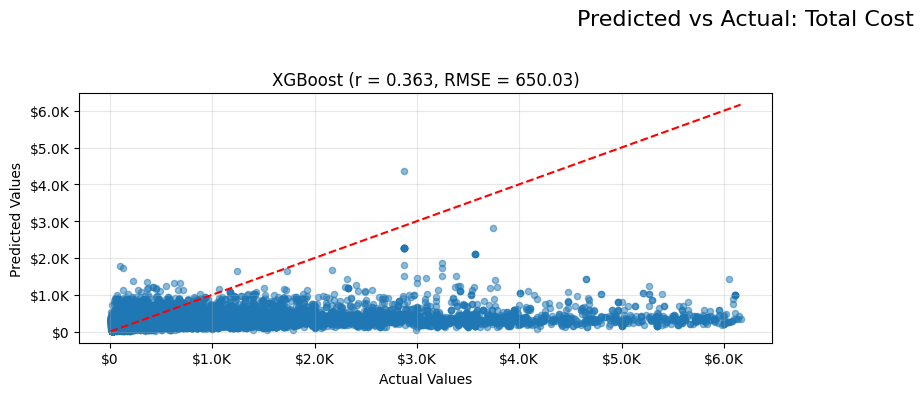

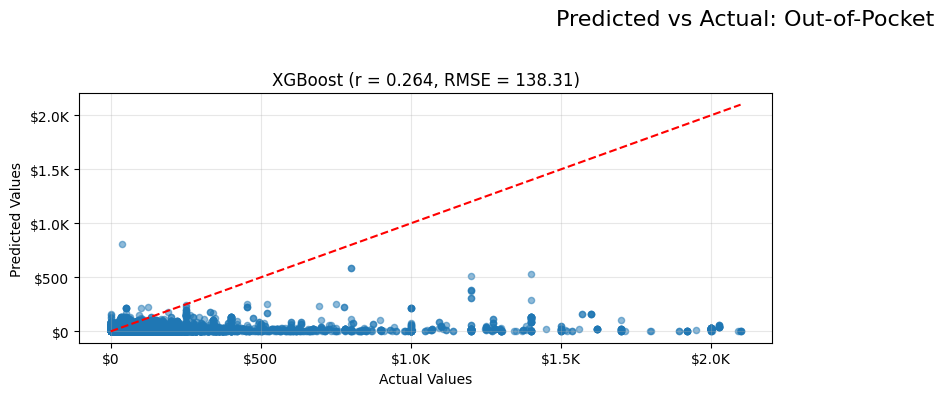

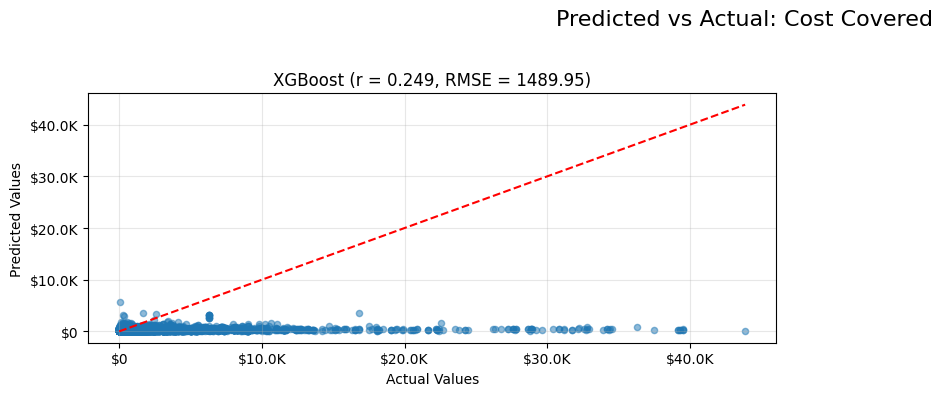

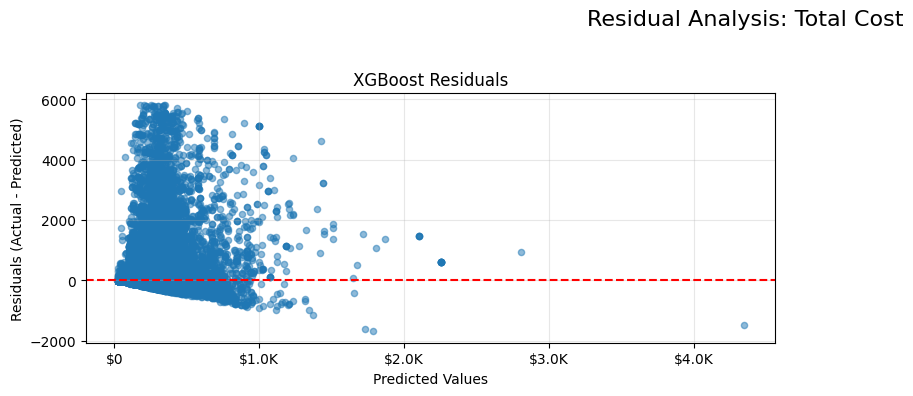

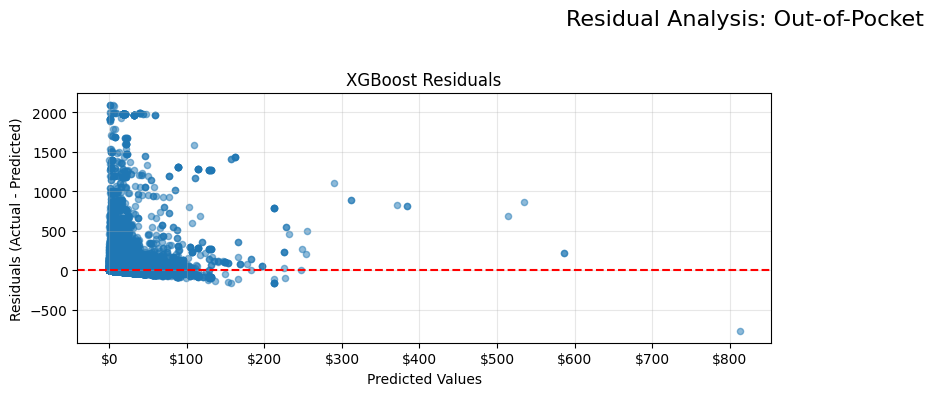

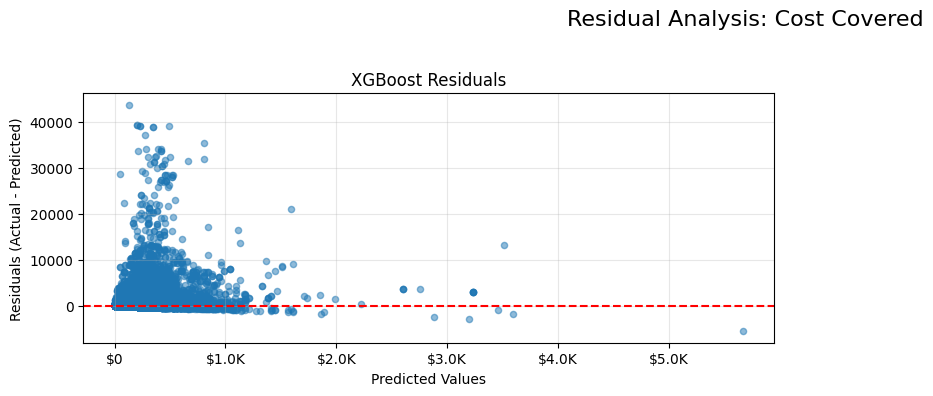

In [144]:
# Add this after your model training loop to create prediction vs actual visualizations

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib.gridspec as gridspec

# Dictionary to store predictions for visualization
predictions_by_cost = {}

# Modify your model training loop to store predictions
for target_name, y in log_targets.items():
    print(f"\nPrediction: {target_name}")
    start_target = time.time()
    
    # (Keep your existing data preparation code)
    df_model = pd.concat([X, y], axis=1)
    df_model = df_model.dropna()
    
    if len(df_model) < 100:
        print(f"Warning: Only {len(df_model)} valid rows for {target_name}")
        continue
        
    # (Keep your existing code for checking -inf values, cleaning data and train/test split)
    if (y == -np.inf).any():
        print(f"Warning: {target_name} contains -inf values from log(0)")

    X_clean = df_model[feature_cols]
    y_clean = df_model[y.name]
    X_clean, y_clean = remove_target_outliers(X_clean, y_clean, std_dev=3)
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42
    )
    
    # Store the predictions for this cost type
    cost_type = target_name.replace('Log ', '')
    predictions_by_cost[cost_type] = {'actual': np.expm1(y_test)}
    
    try:
        for model_name, model in models.items():
            # (Keep your existing model fitting code)
            start_model = time.time()
            pipe = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('model', model)
            ])

            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)
            
            # Store predictions for visualization
            predictions_by_cost[cost_type][f'{model_name}_pred'] = np.expm1(y_pred)
            
            # (Keep your existing metrics calculation code)
            
    except Exception as e:
        print(f"Error training model for {target_name}: {str(e)}")

# Create prediction vs actual plots
def currency_formatter(x, pos):
    """Format numbers as currency with K for thousands, M for millions"""
    if x >= 1e6:
        return f'${x/1e6:.1f}M'
    elif x >= 1e3:
        return f'${x/1e3:.1f}K'
    else:
        return f'${x:.0f}'

# Create a figure for each cost type
for cost_type, predictions in predictions_by_cost.items():
    actual_values = predictions['actual']
    
    # Get the number of models
    model_names = [key.replace('_pred', '') for key in predictions.keys() if key != 'actual']
    n_models = len(model_names)
    
    if n_models == 0:
        continue
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 4 * ((n_models + 1) // 2)))
    gs = gridspec.GridSpec(((n_models + 1) // 2), 2)
    
    # Add title to the figure
    fig.suptitle(f'Predicted vs Actual: {cost_type}', fontsize=16, y=0.98)
    
    for i, model_name in enumerate(model_names):
        ax = plt.subplot(gs[i // 2, i % 2])
        predicted_values = predictions[f'{model_name}_pred']
        
        # Create scatter plot
        ax.scatter(actual_values, predicted_values, alpha=0.5, s=20)
        
        # Add diagonal line representing perfect prediction
        max_val = max(actual_values.max(), predicted_values.max())
        min_val = min(actual_values.min(), predicted_values.min())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        # Add correlation coefficient
        corr = np.corrcoef(actual_values, predicted_values)[0, 1]
        rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
        
        # Set titles and labels
        ax.set_title(f'{model_name} (r = {corr:.3f}, RMSE = {rmse:.2f})')
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        
        # Format axes as currency
        ax.xaxis.set_major_formatter(FuncFormatter(currency_formatter))
        ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
        
        # Add grid
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'{cost_type}_predictions.png', dpi=300)
    plt.show()

# Generate residual plots to show prediction error
for cost_type, predictions in predictions_by_cost.items():
    actual_values = predictions['actual']
    
    # Get the number of models
    model_names = [key.replace('_pred', '') for key in predictions.keys() if key != 'actual']
    n_models = len(model_names)
    
    if n_models == 0:
        continue
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 4 * ((n_models + 1) // 2)))
    gs = gridspec.GridSpec(((n_models + 1) // 2), 2)
    
    # Add title to the figure
    fig.suptitle(f'Residual Analysis: {cost_type}', fontsize=16, y=0.98)
    
    for i, model_name in enumerate(model_names):
        ax = plt.subplot(gs[i // 2, i % 2])
        predicted_values = predictions[f'{model_name}_pred']
        residuals = actual_values - predicted_values
        
        # Create residual plot
        ax.scatter(predicted_values, residuals, alpha=0.5, s=20)
        
        # Add horizontal line at y=0
        ax.axhline(y=0, color='r', linestyle='--')
        
        # Set titles and labels
        ax.set_title(f'{model_name} Residuals')
        ax.set_xlabel('Predicted Values')
        ax.set_ylabel('Residuals (Actual - Predicted)')
        
        # Format x-axis as currency
        ax.xaxis.set_major_formatter(FuncFormatter(currency_formatter))
        
        # Add grid
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'{cost_type}_residuals.png', dpi=300)
    plt.show()